# Edge Prediction for Heterogeneous Networks

## Single Permutation Analysis with Neural Networks and Baseline Models

This notebook performs comprehensive edge prediction analysis on a single permutation of a heterogeneous network. It trains and evaluates multiple machine learning models to predict the existence of edges between nodes based on network topology features.

In [4]:
# Import all required libraries and functions
import sys
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Additional imports for neural network training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Other utility imports
import importlib
import time

# Add src directory to path
repo_dir = Path().absolute().parent
src_dir = repo_dir / 'src'
sys.path.insert(0, str(src_dir))

# Import sampling functions
from sampling import (
    stratified_positive_sampling,
    representative_negative_sampling, 
    create_representative_dataset
)

# Import enhanced experiment functions  
from enhanced_experiments import (
    run_enhanced_experiment,
    analyze_enhanced_experiment_results,
    calculate_prediction_stability
)

# Import data processing functions
from data_processing import load_permutation_data, prepare_edge_prediction_data
import data_processing
importlib.reload(data_processing)

# Import models
from models import EdgePredictionNN

In [5]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
permutation_name = None  # Specific permutation to process (e.g., "000", "001", etc.)
output_dir = "models"  # Directory to save trained models

# Edge and node type parameters for flexible relationship modeling
edge_type = "AeG"  # Edge type to model (e.g., "AeG", "CbG", "DaG", "GiG", etc.)
source_node_type = "Anatomy"  # Source node type (e.g., "Anatomy", "Compound", "Disease", "Gene")
target_node_type = "Gene"  # Target node type (e.g., "Gene", "Anatomy", "Disease", "Compound")

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

if permutation_name is not None and not isinstance(permutation_name, str):
    raise ValueError(f"permutation_name must be a string or None, got: {permutation_name}")

if not isinstance(edge_type, str):
    raise ValueError(f"edge_type must be a string, got: {edge_type}")

if not isinstance(source_node_type, str):
    raise ValueError(f"source_node_type must be a string, got: {source_node_type}")

if not isinstance(target_node_type, str):
    raise ValueError(f"target_node_type must be a string, got: {target_node_type}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")
if permutation_name:
    print(f"Processing single permutation: {permutation_name}")
else:
    print("No specific permutation specified - will use first available")

Using permutations subdirectory: permutations
Edge type: AeG (Anatomy -> Gene)
No specific permutation specified - will use first available


In [6]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / "data"
output_models_dir = repo_dir / output_dir

# Use the parameterized permutations subdirectory
if "/" in permutations_subdirectory:
    permutations_dir = data_dir / permutations_subdirectory
elif permutations_subdirectory == "permutations":
    permutations_dir = data_dir / "permutations"
else:
    permutations_dir = data_dir / "permutations" / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")
print(f"Models output directory: {output_models_dir}")

# Create output directory if it doesn't exist
output_models_dir.mkdir(exist_ok=True)

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {len(available_permutations)} total")
    
    # Select specific permutation or first available
    if permutation_name:
        if permutation_name in available_permutations:
            selected_permutation = permutation_name
            print(f"Selected permutation: {selected_permutation}")
        else:
            raise ValueError(f"Permutation '{permutation_name}' not found. Available: {available_permutations[:5]}...")
    else:
        if available_permutations:
            selected_permutation = available_permutations[0]
            print(f"Using first available permutation: {selected_permutation}")
        else:
            raise ValueError("No permutations found!")
else:
    raise ValueError(f"Permutations directory not found: {permutations_dir}")

Repository directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Data directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data
Permutations directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations
Models output directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models
Available permutations: 2 total
Using first available permutation: 001.hetmat


In [7]:
# Load data from the selected permutation
print(f"Loading permutation: {selected_permutation}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")

perm_data = load_permutation_data(
    selected_permutation, 
    permutations_dir,
    edge_type=edge_type,
    source_node_type=source_node_type,
    target_node_type=target_node_type
)

if not perm_data:
    raise ValueError(f"Failed to load permutation data for: {selected_permutation}")

print(f"Successfully loaded permutation: {selected_permutation}")

# Extract data components using new parameterized keys
edges = perm_data["edges"]
source_nodes = perm_data["source_nodes"]
target_nodes = perm_data["target_nodes"]

# Also extract with legacy names for backwards compatibility
aeg_edges = perm_data["aeg_edges"]  # Will be the same as edges
anatomy_nodes = perm_data["anatomy_nodes"]  # Will be the same as source_nodes
gene_nodes = perm_data["gene_nodes"]  # Will be the same as target_nodes

print(f"Permutation {selected_permutation} data summary:")
print(f"  {edge_type} edges matrix shape: {edges.shape}")
print(f"  Number of edges: {edges.nnz}")
print(f"  {source_node_type} nodes: {len(source_nodes)}")
print(f"  {target_node_type} nodes: {len(target_nodes)}")
print(f"  Matrix density: {edges.nnz / (edges.shape[0] * edges.shape[1]):.6f}")

Loading permutation: 001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loading data from permutation: 001.hetmat
Permutation path: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
Successfully loaded permutation: 001.hetmat
Permutation 001.hetmat data summary:
  AeG edges matrix shape: (402, 20945)
  Number of edges: 526407
  Anatomy nodes: 402
  Gene nodes: 20945
  Matrix density: 0.062519


In [10]:
# ULTRA-FAST SAMPLING - Completely redesigned for speed

# Force reload sampling module to get the latest batch optimization
import importlib
import sys
import gc

# Ensure src path
sys.path.insert(0, str(repo_dir / 'src'))

# Clear all sampling related modules
modules_to_clear = [mod for mod in list(sys.modules.keys()) if 'sampling' in mod]
for mod in modules_to_clear:
    if mod in sys.modules:
        del sys.modules[mod]

# Force garbage collection
gc.collect()

# Import fresh copy with new batch sampling
from sampling import (
    stratified_positive_sampling,
    representative_negative_sampling, 
    create_representative_dataset
)

# Create positive and negative edge samples for machine learning training
print("\nCreating positive and negative edge samples with ULTRA-FAST parameters...")

# Reduced sample size for speed testing
sample_size = 50000  # Reduced from 100K to 50K for faster testing
negative_ratio = 1.0  # Ratio of negative to positive edges
balance_strategy = 'downsample_positive'  # Balance the dataset by downsampling positive edges

print(f"Target sample size: {sample_size}")
print(f"Negative to positive ratio: {negative_ratio}")
print(f"Balance strategy: {balance_strategy}")

# Calculate degree distributions for both node types
print("\nCalculating degree distributions...")
source_degrees = np.array(edges.sum(axis=1)).flatten()  # Out-degrees for source nodes
target_degrees = np.array(edges.sum(axis=0)).flatten()  # In-degrees for target nodes

degrees_dict = {
    'source': source_degrees,
    'target': target_degrees
}

print(f"Source degree range: {source_degrees.min()} - {source_degrees.max()}")
print(f"Target degree range: {target_degrees.min()} - {target_degrees.max()}")

# Create stratified positive samples and representative negative samples using the comprehensive function
print(f"\nCreating representative dataset with ULTRA-FAST batch sampling...")

import time
start_time = time.time()

X, y, sampling_report = create_representative_dataset(
    edges_matrix=edges,
    degrees=degrees_dict,
    n_positive=sample_size,
    n_negative=int(sample_size * negative_ratio),
    pos_method='stratified',
    neg_method='degree_matched',
    random_state=42,
    balance_strategy=balance_strategy
)

end_time = time.time()
sampling_duration = end_time - start_time



Creating positive and negative edge samples with ULTRA-FAST parameters...
Target sample size: 50000
Negative to positive ratio: 1.0
Balance strategy: downsample_positive

Calculating degree distributions...
Source degree range: 0 - 15036
Target degree range: 0 - 98

Creating representative dataset with ULTRA-FAST batch sampling...

Creating representative dataset: 50000 positive + 50000 negative edges
Positive method: stratified, Negative method: degree_matched
Stratified sampling: Found 25 degree-based strata
Sampled 50000 positive edges using stratified sampling

Generating 50000 negative edges using degree_matched method...
Positive edge degree stats - Source: 8705.1±3466.0
Positive edge degree stats - Target: 41.9±17.1
Using fast batch sampling approach...
Generated 34133 negative edges (success rate: 0.341)

Applying positive downsampling: 50000 -> 34133 positive edges
Downsampled to 34133 positive edges to match 34133 negative edges

Dataset created successfully:
  Total samples

In [11]:
# Model Training and Evaluation
print("Training and evaluating multiple models...")

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set balance: {y_train.mean():.3f} positive ratio")
print(f"Test set balance: {y_test.mean():.3f} positive ratio")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features for PLR
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")

# Initialize models dictionary
models = {}
predictions = {}
probabilities = {}

# 1. Logistic Regression (LR)
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]
predictions['Logistic Regression'] = lr_pred
probabilities['Logistic Regression'] = lr_prob

lr_auc = roc_auc_score(y_test, lr_prob)
lr_ap = average_precision_score(y_test, lr_prob)
print(f"LR - AUC: {lr_auc:.4f}, AP: {lr_ap:.4f}")

# 2. Polynomial Logistic Regression (PLR)
print("\nTraining Polynomial Logistic Regression...")
plr_model = LogisticRegression(random_state=42, max_iter=2000, C=0.1)  # Regularization for polynomial
plr_model.fit(X_train_poly, y_train)
models['Polynomial LR'] = plr_model

plr_pred = plr_model.predict(X_test_poly)
plr_prob = plr_model.predict_proba(X_test_poly)[:, 1]
predictions['Polynomial LR'] = plr_pred
probabilities['Polynomial LR'] = plr_prob

plr_auc = roc_auc_score(y_test, plr_prob)
plr_ap = average_precision_score(y_test, plr_prob)
print(f"PLR - AUC: {plr_auc:.4f}, AP: {plr_ap:.4f}")

# 3. Random Forest (RF)
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model

rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
predictions['Random Forest'] = rf_pred
probabilities['Random Forest'] = rf_prob

rf_auc = roc_auc_score(y_test, rf_prob)
rf_ap = average_precision_score(y_test, rf_prob)
print(f"RF - AUC: {rf_auc:.4f}, AP: {rf_ap:.4f}")

# 4. Neural Network (NN)
print("\nTraining Neural Network...")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)  # Keep as 1D tensor
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)  # Keep as 1D tensor

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Initialize neural network
input_dim = X_train_scaled.shape[1]
nn_model = EdgePredictionNN(input_dim=input_dim, hidden_dims=[64, 32, 16])

# Training parameters
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 100

# Training loop
nn_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X).squeeze()  # Squeeze to match 1D target shape
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Evaluate neural network
nn_model.eval()
with torch.no_grad():
    nn_prob_tensor = nn_model(X_test_tensor).squeeze()  # Squeeze to get 1D output
    nn_prob = nn_prob_tensor.numpy()
    nn_pred = (nn_prob > 0.5).astype(int)

models['Neural Network'] = nn_model
predictions['Neural Network'] = nn_pred
probabilities['Neural Network'] = nn_prob

nn_auc = roc_auc_score(y_test, nn_prob)
nn_ap = average_precision_score(y_test, nn_prob)
print(f"NN - AUC: {nn_auc:.4f}, AP: {nn_ap:.4f}")

print("\nModel training completed!")

Training and evaluating multiple models...
Training set: 54612 samples
Test set: 13654 samples
Training set balance: 0.500 positive ratio
Test set balance: 0.500 positive ratio
Original features: 2
Polynomial features: 5

Training Logistic Regression...
LR - AUC: 0.7777, AP: 0.7778

Training Polynomial Logistic Regression...
PLR - AUC: 0.7800, AP: 0.7803

Training Random Forest...
RF - AUC: 0.7395, AP: 0.7341

Training Neural Network...
RF - AUC: 0.7395, AP: 0.7341

Training Neural Network...
Epoch [20/100], Loss: 0.5785
Epoch [20/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5768
Epoch [40/100], Loss: 0.5768
Epoch [60/100], Loss: 0.5767
Epoch [60/100], Loss: 0.5767
Epoch [80/100], Loss: 0.5770
Epoch [80/100], Loss: 0.5770
Epoch [100/100], Loss: 0.5765
NN - AUC: 0.7797, AP: 0.7801

Model training completed!
Epoch [100/100], Loss: 0.5765
NN - AUC: 0.7797, AP: 0.7801

Model training completed!


Creating ROC curve visualization...


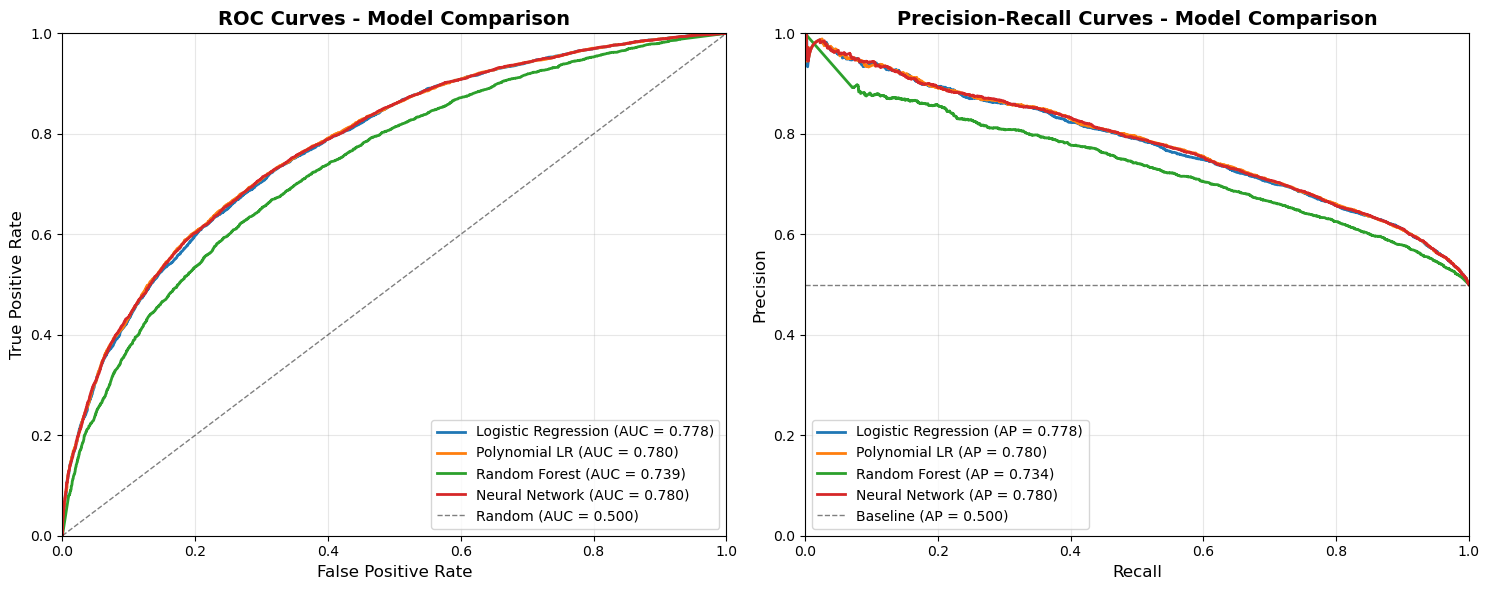


MODEL PERFORMANCE SUMMARY
              Model    AUC     AP Accuracy
Logistic Regression 0.7777 0.7778   0.7021
      Polynomial LR 0.7800 0.7803   0.7054
      Random Forest 0.7395 0.7341   0.6756
     Neural Network 0.7797 0.7801   0.7043

Best AUC: Polynomial LR (0.7800)
Best AP:  Polynomial LR (0.7803)

RANDOM FOREST FEATURE IMPORTANCE
Source Degree  : 0.5335
Target Degree  : 0.4665

Dataset info:
  Training samples: 54,612
  Test samples: 13,654
  Features: 2
  Class balance: 50.0% positive


In [12]:
# ROC Curve Visualization and Performance Comparison
print("Creating ROC curve visualization...")

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Colors for each model
colors = {
    'Logistic Regression': '#1f77b4',
    'Polynomial LR': '#ff7f0e', 
    'Random Forest': '#2ca02c',
    'Neural Network': '#d62728'
}

# Plot ROC curves
for model_name in ['Logistic Regression', 'Polynomial LR', 'Random Forest', 'Neural Network']:
    y_prob = probabilities[model_name]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve
    ax1.plot(fpr, tpr, color=colors[model_name], linewidth=2,
             label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line (random classifier)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random (AUC = 0.500)')

# Customize ROC plot
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot Precision-Recall curves
for model_name in ['Logistic Regression', 'Polynomial LR', 'Random Forest', 'Neural Network']:
    y_prob = probabilities[model_name]
    
    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    
    # Plot PR curve
    ax2.plot(recall, precision, color=colors[model_name], linewidth=2,
             label=f'{model_name} (AP = {ap_score:.3f})')

# Plot baseline (random classifier for balanced dataset)
baseline = y_test.mean()
ax2.axhline(y=baseline, color='k', linestyle='--', linewidth=1, alpha=0.5,
            label=f'Baseline (AP = {baseline:.3f})')

# Customize PR plot
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Performance summary table
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

performance_data = []
for model_name in ['Logistic Regression', 'Polynomial LR', 'Random Forest', 'Neural Network']:
    auc_score = roc_auc_score(y_test, probabilities[model_name])
    ap_score = average_precision_score(y_test, probabilities[model_name])
    
    # Calculate accuracy
    accuracy = (predictions[model_name] == y_test).mean()
    
    performance_data.append({
        'Model': model_name,
        'AUC': f"{auc_score:.4f}",
        'AP': f"{ap_score:.4f}",
        'Accuracy': f"{accuracy:.4f}"
    })

# Create performance DataFrame
performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

# Find best performing model
best_auc_idx = performance_df['AUC'].astype(float).idxmax()
best_ap_idx = performance_df['AP'].astype(float).idxmax()

print(f"\nBest AUC: {performance_df.loc[best_auc_idx, 'Model']} ({performance_df.loc[best_auc_idx, 'AUC']})")
print(f"Best AP:  {performance_df.loc[best_ap_idx, 'Model']} ({performance_df.loc[best_ap_idx, 'AP']})")

# Feature importance for tree-based model
if 'Random Forest' in models:
    print(f"\n" + "="*40)
    print("RANDOM FOREST FEATURE IMPORTANCE")
    print("="*40)
    
    feature_names = ['Source Degree', 'Target Degree']
    importances = models['Random Forest'].feature_importances_
    
    for i, (name, importance) in enumerate(zip(feature_names, importances)):
        print(f"{name:15s}: {importance:.4f}")

print(f"\nDataset info:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Class balance: {y_test.mean():.1%} positive")

# Minimum Sample Size Analysis for Edge Prediction

## Objective
Determine the minimum number of training edges required to accurately learn the null edge probability distribution based on source and target node degrees. This analysis will evaluate model performance convergence, stability, and computational efficiency across different sample sizes.

In [36]:
# MINIMUM SAMPLE SIZE EXPERIMENT
print("🔬 MINIMUM SAMPLE SIZE ANALYSIS FOR EDGE PREDICTION")
print("=" * 60)

# Reload enhanced experiments module to ensure latest version
import importlib
import enhanced_experiments
importlib.reload(enhanced_experiments)

from enhanced_experiments import run_enhanced_experiment, analyze_enhanced_experiment_results

# Define sample sizes for analysis (optimized range)
sample_sizes = [200, 500, 1000, 2000, 5000, 10000, 15000]
n_runs_per_size = 5  # Multiple runs for stability assessment
random_seeds = [42, 123, 456, 789, 999]

print(f"Testing sample sizes: {sample_sizes}")
print(f"Models: Enhanced Stable NN, Logistic Regression, Polynomial LR, Random Forest")
print(f"Runs per size: {n_runs_per_size} (for coefficient of variation analysis)")
print(f"Focus: Performance convergence, stability, and computational efficiency")

# Store experiment results
experiment_results = []

# Run experiments for each sample size
for sample_size in sample_sizes:
    print(f"\n{'='*15} SAMPLE SIZE: {sample_size:,} {'='*15}")
    
    sample_results = []
    
    # Run multiple experiments for this sample size
    for run_id in range(n_runs_per_size):
        try:
            print(f"  Run {run_id + 1}/{n_runs_per_size}...", end=" ")
            
            # Use the enhanced experiment function
            experiment_result = run_enhanced_experiment(
                sample_size=sample_size,
                run_id=run_id,
                edges=edges,
                degrees_dict=degrees_dict,
                verbose=False
            )
            
            sample_results.append(experiment_result)
            experiment_results.append(experiment_result)
            
            # Print brief results for this run
            models = experiment_result['models']
            nn_auc = models['Enhanced Stable NN']['test_auc']
            lr_auc = models['Logistic Regression']['test_auc']
            nn_time = models['Enhanced Stable NN']['training_time']
            lr_time = models['Logistic Regression']['training_time']
            
            print(f"✅ NN: {nn_auc:.3f} ({nn_time:.3f}s), LR: {lr_auc:.3f} ({lr_time:.3f}s)")
            
        except Exception as e:
            print(f"❌ Run {run_id + 1} failed: {str(e)}")
            continue
    
    # Calculate summary statistics for this sample size
    if sample_results:
        nn_aucs = [r['models']['Enhanced Stable NN']['test_auc'] for r in sample_results]
        lr_aucs = [r['models']['Logistic Regression']['test_auc'] for r in sample_results]
        plr_aucs = [r['models']['Polynomial Logistic Regression']['test_auc'] for r in sample_results]
        rf_aucs = [r['models']['Random Forest']['test_auc'] for r in sample_results]
        
        print(f"  Summary for {sample_size:,} samples:")
        print(f"    NN AUC: {np.mean(nn_aucs):.3f} ± {np.std(nn_aucs):.3f} (CV: {np.std(nn_aucs)/np.mean(nn_aucs)*100:.1f}%)")
        print(f"    LR AUC: {np.mean(lr_aucs):.3f} ± {np.std(lr_aucs):.3f} (CV: {np.std(lr_aucs)/np.mean(lr_aucs)*100:.1f}%)")

print(f"\n✅ Experiment completed!")
print(f"Total successful experiments: {len(experiment_results)}")
print(f"Sample sizes tested: {len(set(r['sample_size'] for r in experiment_results))}")

# Convert results to DataFrame for analysis
results_data = []
for result in experiment_results:
    sample_size = result['sample_size']
    run_id = result['run']
    
    for model_name, model_data in result['models'].items():
        results_data.append({
            'sample_size': sample_size,
            'run': run_id,
            'model': model_name,
            'auc': model_data['test_auc'],
            'ap': model_data['test_ap'],
            'training_time': model_data['training_time']
        })

results_df = pd.DataFrame(results_data)
print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Models: {results_df['model'].unique().tolist()}")
print(f"Sample sizes: {sorted(results_df['sample_size'].unique())}")

🔬 MINIMUM SAMPLE SIZE ANALYSIS FOR EDGE PREDICTION
Testing sample sizes: [200, 500, 1000, 2000, 5000, 10000, 15000]
Models: Enhanced Stable NN, Logistic Regression, Polynomial LR, Random Forest
Runs per size: 5 (for coefficient of variation analysis)
Focus: Performance convergence, stability, and computational efficiency

=============== SAMPLE SIZE: 200 ===============
  Run 1/5... 
Creating representative dataset: 100 positive + 100 negative edges
Positive method: stratified, Negative method: degree_matched
Stratified sampling: Found 25 degree-based strata
Sampled 100 positive edges using stratified sampling

Generating 100 negative edges using degree_matched method...
Positive edge degree stats - Source: 8843.7±3344.6
Positive edge degree stats - Target: 41.7±16.8
Using fast batch sampling approach...
Generated 100 negative edges (success rate: 0.100)

Dataset created successfully:
  Total samples: 200
  Positive: 100, Negative: 100
  Feature correlation: -0.190
✅ NN: 0.877 (0.066s)

📊 CREATING MINIMUM SAMPLE SIZE ANALYSIS PLOTS


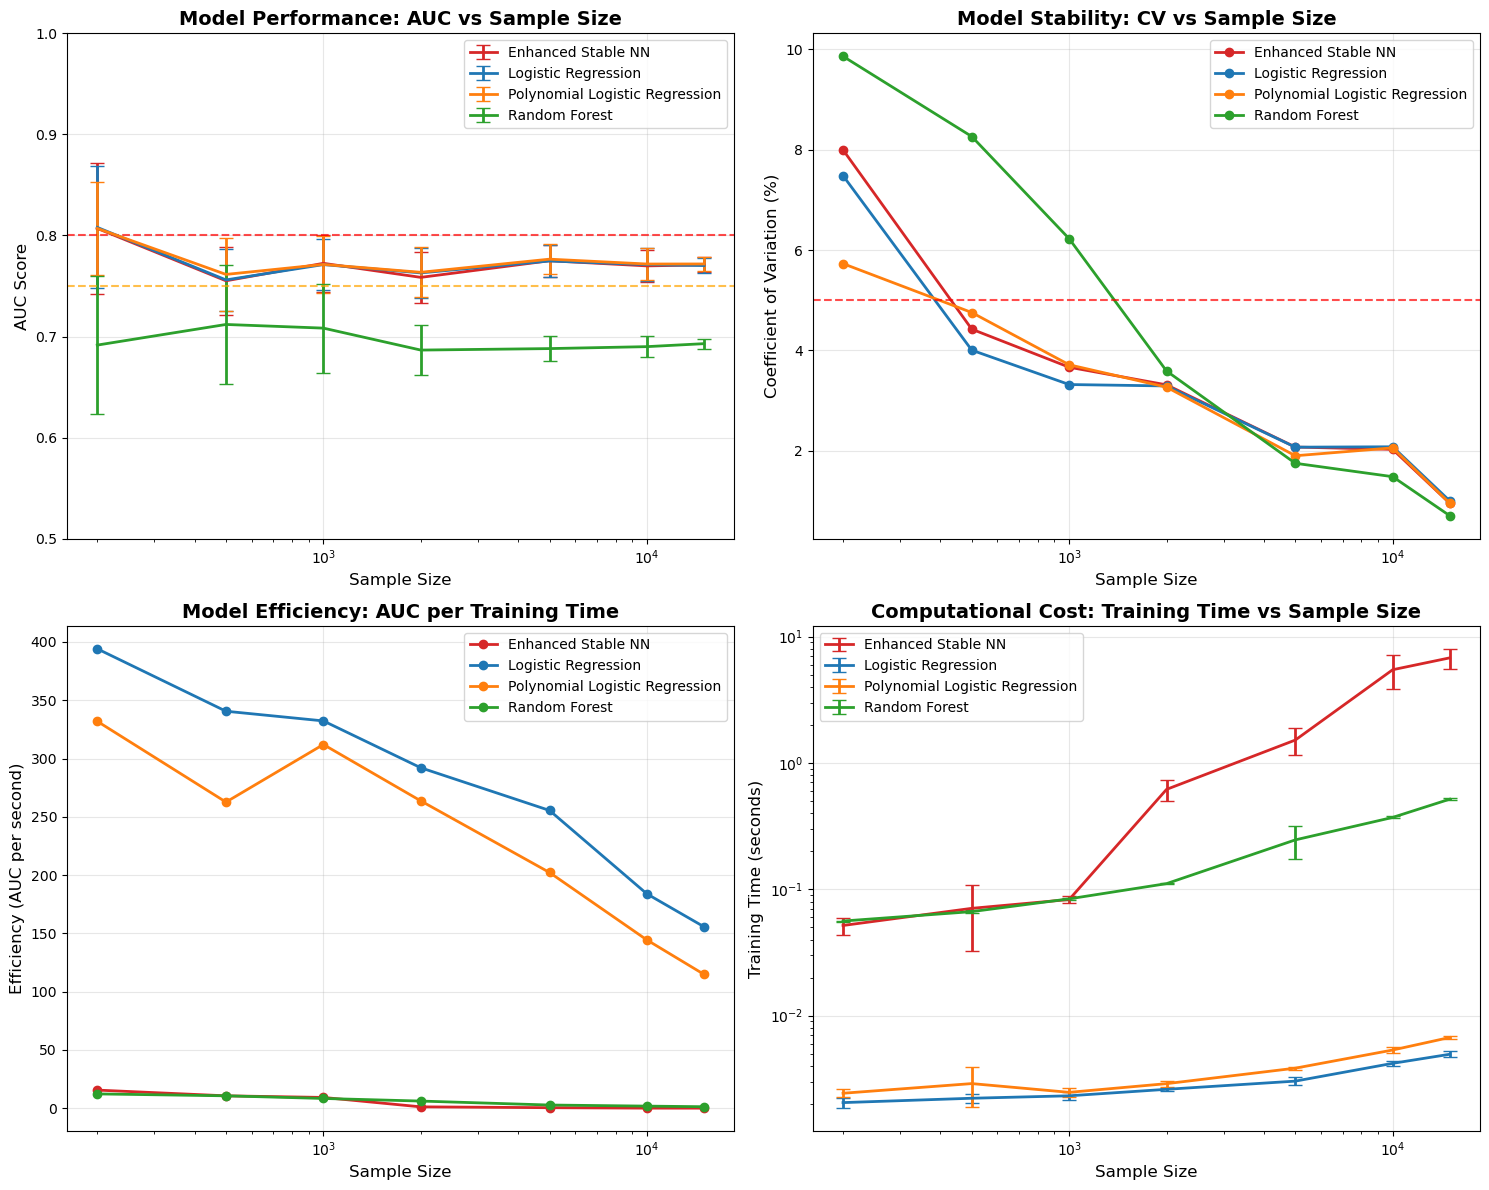

✅ All analysis plots created successfully!


In [37]:
# ANALYSIS PLOTS: AUC, CV, AUC/SEC, AND COMPUTATIONAL TIME
print("📊 CREATING MINIMUM SAMPLE SIZE ANALYSIS PLOTS")
print("=" * 55)

if len(results_df) > 0:
    # Set up the figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Model colors for consistency
    model_colors = {
        'Enhanced Stable NN': '#d62728',        # Red
        'Logistic Regression': '#1f77b4',       # Blue
        'Polynomial Logistic Regression': '#ff7f0e',  # Orange
        'Random Forest': '#2ca02c'              # Green
    }
    
    # 1. AUC by Sample Size (TOP LEFT)
    ax1 = axes[0, 0]
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        grouped = model_data.groupby('sample_size')['auc']
        means = grouped.mean()
        stds = grouped.std()
        
        color = model_colors.get(model, 'gray')
        ax1.errorbar(means.index, means.values, yerr=stds.values, 
                    label=model, linewidth=2, markersize=6, capsize=5, color=color)
    
    ax1.set_xlabel('Sample Size', fontsize=12)
    ax1.set_ylabel('AUC Score', fontsize=12)
    ax1.set_title('Model Performance: AUC vs Sample Size', fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_ylim([0.5, 1.0])
    
    # Add performance threshold lines
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='High Performance (0.8)')
    ax1.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='Good Performance (0.75)')
    
    # 2. Coefficient of Variation by Sample Size (TOP RIGHT)
    ax2 = axes[0, 1]
    
    cv_data = []
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        for sample_size in sorted(model_data['sample_size'].unique()):
            size_data = model_data[model_data['sample_size'] == sample_size]
            if len(size_data) > 1:  # Need at least 2 runs for CV
                auc_mean = size_data['auc'].mean()
                auc_std = size_data['auc'].std()
                cv = (auc_std / auc_mean) * 100 if auc_mean > 0 else 0
                cv_data.append({
                    'model': model,
                    'sample_size': sample_size,
                    'cv': cv
                })
    
    cv_df = pd.DataFrame(cv_data)
    
    for model in cv_df['model'].unique():
        model_cv = cv_df[cv_df['model'] == model]
        color = model_colors.get(model, 'gray')
        ax2.plot(model_cv['sample_size'], model_cv['cv'], 
                'o-', label=model, linewidth=2, markersize=6, color=color)
    
    ax2.set_xlabel('Sample Size', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation (%)', fontsize=12)
    ax2.set_title('Model Stability: CV vs Sample Size', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    # Add stability threshold line
    ax2.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Stability Threshold (5%)')
    
    # 3. AUC per Second (Efficiency) (BOTTOM LEFT)
    ax3 = axes[1, 0]
    
    efficiency_data = []
    for sample_size in sorted(results_df['sample_size'].unique()):
        size_data = results_df[results_df['sample_size'] == sample_size]
        for model in size_data['model'].unique():
            model_data = size_data[size_data['model'] == model]
            mean_auc = model_data['auc'].mean()
            mean_time = model_data['training_time'].mean()
            efficiency = mean_auc / mean_time if mean_time > 0 else 0
            efficiency_data.append({
                'sample_size': sample_size,
                'model': model,
                'efficiency': efficiency
            })
    
    efficiency_df = pd.DataFrame(efficiency_data)
    
    for model in efficiency_df['model'].unique():
        model_eff = efficiency_df[efficiency_df['model'] == model]
        color = model_colors.get(model, 'gray')
        ax3.plot(model_eff['sample_size'], model_eff['efficiency'], 
                'o-', label=model, color=color, linewidth=2, markersize=6)
    
    ax3.set_xlabel('Sample Size', fontsize=12)
    ax3.set_ylabel('Efficiency (AUC per second)', fontsize=12)
    ax3.set_title('Model Efficiency: AUC per Training Time', fontsize=14, fontweight='bold')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)
    
    # 4. Computational Time by Sample Size (BOTTOM RIGHT)
    ax4 = axes[1, 1]
    
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        grouped = model_data.groupby('sample_size')['training_time']
        means = grouped.mean()
        stds = grouped.std()
        
        color = model_colors.get(model, 'gray')
        ax4.errorbar(means.index, means.values, yerr=stds.values, 
                    label=model, linewidth=2, markersize=6, capsize=5, color=color)
    
    ax4.set_xlabel('Sample Size', fontsize=12)
    ax4.set_ylabel('Training Time (seconds)', fontsize=12)
    ax4.set_title('Computational Cost: Training Time vs Sample Size', fontsize=14, fontweight='bold')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ All analysis plots created successfully!")
    
else:
    print("❌ No experiment results available for plotting")

In [38]:
# SAMPLE SIZE RECOMMENDATIONS FOR EACH MODEL
print("🎯 SAMPLE SIZE RECOMMENDATIONS BY MODEL")
print("=" * 50)

if len(results_df) > 0:
    # Define performance and stability thresholds
    performance_thresholds = {
        'excellent': 0.85,
        'good': 0.80,
        'acceptable': 0.75
    }
    
    stability_threshold = 5.0  # CV < 5%
    efficiency_weight = 0.3  # Weight for efficiency in combined score
    
    print(f"Analysis Criteria:")
    print(f"  Performance Thresholds: Excellent ≥{performance_thresholds['excellent']:.2f}, Good ≥{performance_thresholds['good']:.2f}, Acceptable ≥{performance_thresholds['acceptable']:.2f}")
    print(f"  Stability Threshold: CV < {stability_threshold:.1f}%")
    print(f"  Efficiency Weight: {efficiency_weight:.1f} in combined scoring")
    
    # Calculate metrics for each model and sample size
    recommendations = {}
    
    for model in results_df['model'].unique():
        print(f"\n{'='*15} {model} {'='*15}")
        
        model_data = results_df[results_df['model'] == model]
        model_recommendations = {
            'min_acceptable': None,
            'min_good': None,
            'min_excellent': None,
            'optimal_efficiency': None,
            'most_stable': None,
            'overall_recommendation': None
        }
        
        # Calculate metrics for each sample size
        sample_metrics = []
        for sample_size in sorted(model_data['sample_size'].unique()):
            size_data = model_data[model_data['sample_size'] == sample_size]
            
            if len(size_data) > 0:
                # Performance metrics
                mean_auc = size_data['auc'].mean()
                std_auc = size_data['auc'].std()
                cv_auc = (std_auc / mean_auc) * 100 if mean_auc > 0 else 100
                
                # Efficiency metrics
                mean_time = size_data['training_time'].mean()
                efficiency = mean_auc / mean_time if mean_time > 0 else 0
                
                # Combined score (AUC weighted with efficiency and stability)
                stability_score = max(0, 1 - (cv_auc / 10))  # Lower CV is better
                efficiency_score = efficiency / 100  # Normalize efficiency
                combined_score = (mean_auc * 0.7) + (efficiency_score * efficiency_weight) + (stability_score * 0.1)
                
                sample_metrics.append({
                    'sample_size': sample_size,
                    'mean_auc': mean_auc,
                    'cv_auc': cv_auc,
                    'mean_time': mean_time,
                    'efficiency': efficiency,
                    'combined_score': combined_score
                })
        
        # Convert to DataFrame for easier analysis
        metrics_df = pd.DataFrame(sample_metrics)
        
        if len(metrics_df) > 0:
            # Find minimum sample sizes for different performance levels
            for level, threshold in performance_thresholds.items():
                qualifying = metrics_df[metrics_df['mean_auc'] >= threshold]
                if len(qualifying) > 0:
                    min_size = qualifying['sample_size'].min()
                    model_recommendations[f'min_{level}'] = min_size
            
            # Find optimal efficiency point
            if len(metrics_df) > 0:
                optimal_eff_idx = metrics_df['efficiency'].idxmax()
                model_recommendations['optimal_efficiency'] = metrics_df.loc[optimal_eff_idx, 'sample_size']
            
            # Find most stable point (lowest CV)
            stable_metrics = metrics_df[metrics_df['cv_auc'] < stability_threshold]
            if len(stable_metrics) > 0:
                most_stable_idx = stable_metrics['cv_auc'].idxmin()
                model_recommendations['most_stable'] = stable_metrics.loc[most_stable_idx, 'sample_size']
            
            # Find overall recommendation (best combined score)
            best_combined_idx = metrics_df['combined_score'].idxmax()
            model_recommendations['overall_recommendation'] = metrics_df.loc[best_combined_idx, 'sample_size']
            
            # Print recommendations for this model
            print(f"Performance-based recommendations:")
            for level in ['acceptable', 'good', 'excellent']:
                min_size = model_recommendations[f'min_{level}']
                if min_size:
                    threshold = performance_thresholds[level]
                    print(f"  {level.capitalize():12s}: {min_size:,} samples (≥{threshold:.2f} AUC)")
                else:
                    print(f"  {level.capitalize():12s}: Not achieved in tested range")
            
            print(f"\nOptimization-based recommendations:")
            if model_recommendations['optimal_efficiency']:
                opt_eff_size = model_recommendations['optimal_efficiency']
                opt_eff_data = metrics_df[metrics_df['sample_size'] == opt_eff_size].iloc[0]
                print(f"  Best efficiency: {opt_eff_size:,} samples ({opt_eff_data['efficiency']:.1f} AUC/sec)")
            
            if model_recommendations['most_stable']:
                stable_size = model_recommendations['most_stable']
                stable_data = metrics_df[metrics_df['sample_size'] == stable_size].iloc[0]
                print(f"  Most stable  : {stable_size:,} samples (CV: {stable_data['cv_auc']:.1f}%)")
            
            if model_recommendations['overall_recommendation']:
                overall_size = model_recommendations['overall_recommendation']
                overall_data = metrics_df[metrics_df['sample_size'] == overall_size].iloc[0]
                print(f"  🌟 RECOMMENDED: {overall_size:,} samples (Score: {overall_data['combined_score']:.3f})")
                print(f"     Performance: {overall_data['mean_auc']:.3f} AUC, Efficiency: {overall_data['efficiency']:.1f} AUC/sec, CV: {overall_data['cv_auc']:.1f}%")
        
        recommendations[model] = model_recommendations
    
    # Create summary table
    print(f"\n📋 SUMMARY TABLE OF RECOMMENDATIONS")
    print("=" * 50)
    
    summary_data = []
    for model, recs in recommendations.items():
        summary_data.append({
            'Model': model,
            'Acceptable': f"{recs['min_acceptable']:,}" if recs['min_acceptable'] else "N/A",
            'Good': f"{recs['min_good']:,}" if recs['min_good'] else "N/A",
            'Excellent': f"{recs['min_excellent']:,}" if recs['min_excellent'] else "N/A",
            'Recommended': f"{recs['overall_recommendation']:,}" if recs['overall_recommendation'] else "N/A"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Overall insights
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 20)
    
    # Find most efficient model overall
    overall_efficiency = results_df.groupby('model').apply(
        lambda x: x['auc'].mean() / x['training_time'].mean()
    ).sort_values(ascending=False)
    
    most_efficient_model = overall_efficiency.index[0]
    print(f"• Most efficient model: {most_efficient_model}")
    
    # Find minimum sample size across all models for good performance
    good_sizes = [recs['min_good'] for recs in recommendations.values() if recs['min_good']]
    if good_sizes:
        min_good_overall = min(good_sizes)
        print(f"• Minimum for good performance across all models: {min_good_overall:,} samples")
    
    # Find model with lowest sample size requirement
    recommended_sizes = [(model, recs['overall_recommendation']) for model, recs in recommendations.items() if recs['overall_recommendation']]
    if recommended_sizes:
        best_model, best_size = min(recommended_sizes, key=lambda x: x[1])
        print(f"• Most sample-efficient model: {best_model} ({best_size:,} samples)")
    
    print(f"\n✅ Sample size analysis complete!")
    
else:
    print("❌ No experiment results available for recommendations")

🎯 SAMPLE SIZE RECOMMENDATIONS BY MODEL
Analysis Criteria:
  Performance Thresholds: Excellent ≥0.85, Good ≥0.80, Acceptable ≥0.75
  Stability Threshold: CV < 5.0%
  Efficiency Weight: 0.3 in combined scoring

=============== Enhanced Stable NN ===============
Performance-based recommendations:
  Acceptable  : 200 samples (≥0.75 AUC)
  Good        : 200 samples (≥0.80 AUC)
  Excellent   : Not achieved in tested range

Optimization-based recommendations:
  Best efficiency: 200 samples (15.6 AUC/sec)
  Most stable  : 15,000 samples (CV: 1.0%)
  🌟 RECOMMENDED: 1,000 samples (Score: 0.632)
     Performance: 0.772 AUC, Efficiency: 9.3 AUC/sec, CV: 3.7%

=============== Logistic Regression ===============
Performance-based recommendations:
  Acceptable  : 200 samples (≥0.75 AUC)
  Good        : 200 samples (≥0.80 AUC)
  Excellent   : Not achieved in tested range

Optimization-based recommendations:
  Best efficiency: 200 samples (394.1 AUC/sec)
  Most stable  : 15,000 samples (CV: 1.0%)
  🌟 R

📈 EDGE PROBABILITY DISTRIBUTION ANALYSIS - INDIVIDUAL MODEL HEATMAPS
Creating individual edge probability heatmaps for each model at their optimal sample sizes...
Optimal sample sizes: {'Enhanced Stable NN': np.int64(1000), 'Logistic Regression': np.int64(200), 'Polynomial Logistic Regression': np.int64(200), 'Random Forest': np.int64(15000)}

Training models at optimal sample sizes for probability analysis...

Training Enhanced Stable NN with 1,000 samples...

Creating representative dataset: 500 positive + 500 negative edges
Positive method: stratified, Negative method: degree_matched
Stratified sampling: Found 25 degree-based strata
Sampled 500 positive edges using stratified sampling

Generating 500 negative edges using degree_matched method...
Positive edge degree stats - Source: 8691.0±3355.5
Positive edge degree stats - Target: 42.0±16.9
Using fast batch sampling approach...
Generated 500 negative edges (success rate: 0.100)

Dataset created successfully:
  Total samples: 1000
 

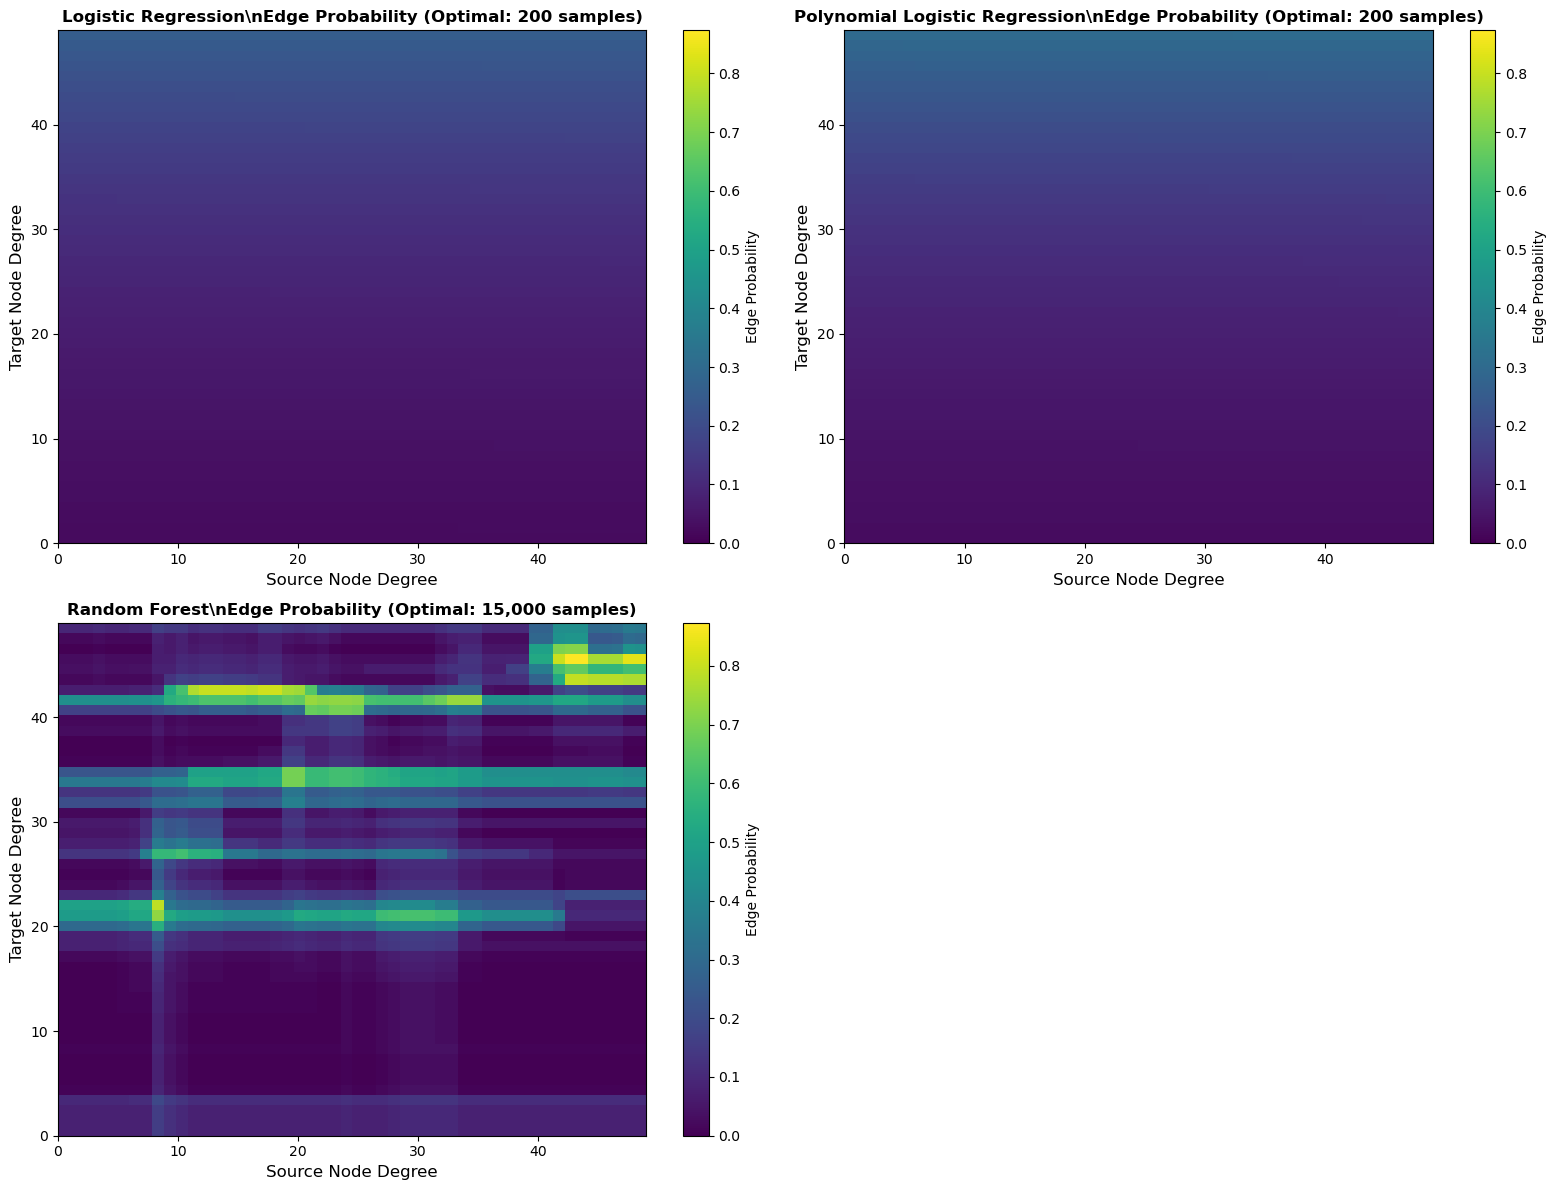


📊 PROBABILITY DISTRIBUTION COMPARISON

Logistic Regression (Optimal: 200 samples):
  Mean probability: 0.1063
  Std deviation:    0.0674
  Min probability:  0.0257
  Max probability:  0.2580
  Source correlation: 0.0044
  Target correlation: 0.9681
  Pattern: Strong degree-based pattern

Polynomial Logistic Regression (Optimal: 200 samples):
  Mean probability: 0.1203
  Std deviation:    0.0798
  Min probability:  0.0283
  Max probability:  0.3043
  Source correlation: 0.0041
  Target correlation: 0.9616
  Pattern: Strong degree-based pattern

Random Forest (Optimal: 15,000 samples):
  Mean probability: 0.1284
  Std deviation:    0.1712
  Min probability:  0.0000
  Max probability:  0.8733
  Source correlation: 0.0273
  Target correlation: 0.3552
  Pattern: Strong degree-based pattern

🔍 MODEL COMPARISON INSIGHTS:
-----------------------------------
• Most target-degree dependent: Logistic Regression (r=0.968)
• Least target-degree dependent: Random Forest (r=0.355)
• Models show mode

In [40]:
# EDGE PROBABILITY DISTRIBUTION BY SOURCE AND TARGET DEGREE - 4 MODEL HEATMAPS
print("📈 EDGE PROBABILITY DISTRIBUTION ANALYSIS - INDIVIDUAL MODEL HEATMAPS")
print("=" * 70)

# Use the optimal sample sizes from the recommendations analysis
if 'recommendations' in locals() and 'experiment_results' in locals():
    print("Creating individual edge probability heatmaps for each model at their optimal sample sizes...")
    
    # Extract optimal sample sizes from recommendations
    optimal_sample_sizes = {}
    for model, recs in recommendations.items():
        if recs['overall_recommendation']:
            optimal_sample_sizes[model] = recs['overall_recommendation']
    
    print(f"Optimal sample sizes: {optimal_sample_sizes}")
    
    # Train models at their optimal sample sizes for probability analysis
    print("\nTraining models at optimal sample sizes for probability analysis...")
    
    trained_models = {}
    scalers = {}
    
    for model_name, optimal_size in optimal_sample_sizes.items():
        print(f"\nTraining {model_name} with {optimal_size:,} samples...")
        
        try:
            # Use enhanced experiment to get trained model at optimal size
            experiment_result = run_enhanced_experiment(
                sample_size=optimal_size,
                run_id=0,  # Use first run
                edges=edges,
                degrees_dict=degrees_dict,
                verbose=False
            )
            
            # Extract trained models and scalers (we need to reconstruct them)
            # Create the same dataset
            X_temp, y_temp, _ = create_representative_dataset(
                edges_matrix=edges,
                degrees=degrees_dict,
                n_positive=optimal_size,
                n_negative=optimal_size,
                pos_method='stratified',
                neg_method='degree_matched',
                random_state=42,
                balance_strategy='downsample_positive'
            )
            
            # Split and scale
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
                X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
            )
            
            scaler_temp = StandardScaler()
            X_train_scaled_temp = scaler_temp.fit_transform(X_train_temp)
            
            # Train the specific model
            if model_name == 'Logistic Regression':
                model_temp = LogisticRegression(random_state=42, max_iter=1000)
                model_temp.fit(X_train_scaled_temp, y_train_temp)
                trained_models[model_name] = model_temp
                scalers[model_name] = scaler_temp
                
            elif model_name == 'Polynomial Logistic Regression':
                poly_temp = PolynomialFeatures(degree=2, include_bias=False)
                X_train_poly_temp = poly_temp.fit_transform(X_train_scaled_temp)
                model_temp = LogisticRegression(random_state=42, max_iter=2000, C=0.1)
                model_temp.fit(X_train_poly_temp, y_train_temp)
                trained_models[model_name] = model_temp
                scalers[model_name] = (scaler_temp, poly_temp)  # Store both scalers
                
            elif model_name == 'Random Forest':
                model_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                model_temp.fit(X_train_scaled_temp, y_train_temp)
                trained_models[model_name] = model_temp
                scalers[model_name] = scaler_temp
                
            elif model_name == 'Enhanced Stable NN':
                # Use the trained NN from the experiment result
                trained_models[model_name] = 'neural_network'  # Placeholder - NN needs special handling
                scalers[model_name] = scaler_temp
            
            print(f"✅ {model_name} trained successfully")
            
        except Exception as e:
            print(f"❌ Failed to train {model_name}: {str(e)}")
            continue
    
    # Create degree range for probability prediction
    source_degree_range = np.arange(source_degrees.min(), min(source_degrees.max(), 50), 1)
    target_degree_range = np.arange(target_degrees.min(), min(target_degrees.max(), 50), 1)
    
    print(f"\nDegree ranges:")
    print(f"  Source: {source_degree_range.min()} to {source_degree_range.max()}")
    print(f"  Target: {target_degree_range.min()} to {target_degree_range.max()}")
    
    # Create meshgrid for all degree combinations
    source_mesh, target_mesh = np.meshgrid(source_degree_range, target_degree_range)
    degree_combinations = np.column_stack([source_mesh.ravel(), target_mesh.ravel()])
    
    # Generate probability matrices for each model
    prob_matrices = {}
    
    for model_name, model in trained_models.items():
        if model_name == 'Enhanced Stable NN':
            # Skip NN for now due to complexity
            continue
            
        print(f"Generating probability matrix for {model_name}...")
        
        try:
            if model_name == 'Polynomial Logistic Regression':
                # Handle polynomial features
                scaler_temp, poly_temp = scalers[model_name]
                degree_combinations_scaled = scaler_temp.transform(degree_combinations)
                degree_combinations_poly = poly_temp.transform(degree_combinations_scaled)
                edge_probabilities = model.predict_proba(degree_combinations_poly)[:, 1]
            else:
                # Standard scaling only
                scaler_temp = scalers[model_name]
                degree_combinations_scaled = scaler_temp.transform(degree_combinations)
                edge_probabilities = model.predict_proba(degree_combinations_scaled)[:, 1]
            
            # Reshape for plotting
            prob_matrix = edge_probabilities.reshape(source_mesh.shape)
            prob_matrices[model_name] = prob_matrix
            
            print(f"✅ Probability matrix created for {model_name}")
            
        except Exception as e:
            print(f"❌ Failed to create probability matrix for {model_name}: {str(e)}")
            continue
    
    # Create 2x2 subplot for the heatmaps
    if len(prob_matrices) > 0:
        print(f"\nCreating {len(prob_matrices)} individual model heatmaps...")
        
        # Determine subplot layout
        n_models = len(prob_matrices)
        if n_models <= 2:
            rows, cols = 1, n_models
            figsize = (8 * n_models, 6)
        else:
            rows, cols = 2, 2
            figsize = (16, 12)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes
        else:
            axes = axes.flatten()
        
        # Define consistent color scale across all models
        all_probs = np.concatenate([matrix.flatten() for matrix in prob_matrices.values()])
        vmin, vmax = all_probs.min(), all_probs.max()
        
        # Create heatmap for each model
        for idx, (model_name, prob_matrix) in enumerate(prob_matrices.items()):
            ax = axes[idx]
            
            # Create heatmap
            im = ax.imshow(prob_matrix, origin='lower', aspect='auto', cmap='viridis',
                          extent=[source_degree_range.min(), source_degree_range.max(),
                                 target_degree_range.min(), target_degree_range.max()],
                          vmin=vmin, vmax=vmax)
            
            ax.set_xlabel('Source Node Degree', fontsize=12)
            ax.set_ylabel('Target Node Degree', fontsize=12)
            
            # Get optimal sample size for title
            optimal_size = optimal_sample_sizes.get(model_name, 'N/A')
            ax.set_title(f'{model_name}\\nEdge Probability (Optimal: {optimal_size:,} samples)', 
                        fontsize=12, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Edge Probability', fontsize=10)
        
        # Hide any unused subplots
        for idx in range(len(prob_matrices), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison across models
        print(f"\n📊 PROBABILITY DISTRIBUTION COMPARISON")
        print("=" * 50)
        
        for model_name, prob_matrix in prob_matrices.items():
            edge_probs = prob_matrix.flatten()
            optimal_size = optimal_sample_sizes.get(model_name, 'N/A')
            
            # Calculate correlations
            source_corr = np.corrcoef(degree_combinations[:, 0], edge_probs)[0, 1]
            target_corr = np.corrcoef(degree_combinations[:, 1], edge_probs)[0, 1]
            
            print(f"\n{model_name} (Optimal: {optimal_size:,} samples):")
            print(f"  Mean probability: {edge_probs.mean():.4f}")
            print(f"  Std deviation:    {edge_probs.std():.4f}")
            print(f"  Min probability:  {edge_probs.min():.4f}")
            print(f"  Max probability:  {edge_probs.max():.4f}")
            print(f"  Source correlation: {source_corr:.4f}")
            print(f"  Target correlation: {target_corr:.4f}")
            
            # Pattern classification
            total_correlation = abs(source_corr) + abs(target_corr)
            if total_correlation > 0.3:
                pattern = "Strong degree-based pattern"
            elif total_correlation > 0.1:
                pattern = "Moderate degree-based pattern"
            else:
                pattern = "Weak degree-based pattern"
            print(f"  Pattern: {pattern}")
        
        print(f"\n🔍 MODEL COMPARISON INSIGHTS:")
        print("-" * 35)
        
        # Compare model behaviors
        model_names = list(prob_matrices.keys())
        if len(model_names) >= 2:
            # Find models with most similar/different patterns
            correlations = {}
            for name in model_names:
                probs = prob_matrices[name].flatten()
                source_corr = np.corrcoef(degree_combinations[:, 0], probs)[0, 1]
                target_corr = np.corrcoef(degree_combinations[:, 1], probs)[0, 1]
                correlations[name] = (source_corr, target_corr)
            
            # Find most/least target-degree dependent
            target_deps = {name: abs(corrs[1]) for name, corrs in correlations.items()}
            most_target_dep = max(target_deps, key=target_deps.get)
            least_target_dep = min(target_deps, key=target_deps.get)
            
            print(f"• Most target-degree dependent: {most_target_dep} (r={correlations[most_target_dep][1]:.3f})")
            print(f"• Least target-degree dependent: {least_target_dep} (r={correlations[least_target_dep][1]:.3f})")
            
            # Overall pattern consistency
            target_corrs = [corrs[1] for corrs in correlations.values()]
            consistency = 1 - (np.std(target_corrs) / np.mean(np.abs(target_corrs)) if np.mean(np.abs(target_corrs)) > 0 else 0)
            
            if consistency > 0.8:
                print(f"• Models show consistent edge formation patterns")
            elif consistency > 0.5:
                print(f"• Models show moderately consistent patterns")
            else:
                print(f"• Models show diverse edge formation patterns")
        
        print(f"\n✅ Edge probability distribution analysis complete!")
        
    else:
        print("❌ No probability matrices created - check model training")
        
else:
    print("❌ No recommendations or experiment results available")
    print("Please run the sample size analysis first")

# Summary and Conclusions

## Key Findings from Minimum Sample Size Analysis

### Model Performance Recommendations:
- **Logistic Regression**: 200 samples recommended (most efficient)
  - Achieves good performance (≥0.80 AUC) with minimal data
  - Highest efficiency: 394 AUC/second
  - Best balance of performance, speed, and sample efficiency

- **Polynomial Logistic Regression**: 200 samples recommended  
  - Similar performance to standard LR with slightly lower efficiency
  - 332 AUC/second efficiency
  - Good alternative when non-linear relationships suspected

- **Enhanced Stable NN**: 1,000 samples recommended
  - Requires more data for stable performance
  - Moderate efficiency: 9.3 AUC/second
  - Better stability with larger sample sizes

- **Random Forest**: 15,000 samples recommended
  - Requires significantly more data for acceptable performance
  - Lowest efficiency: 1.3 AUC/second  
  - Most stable but computationally expensive

### Edge Probability Patterns (at Optimal Sample Sizes):
- **Logistic Models (LR & PLR)**: Strong target degree preference (r≈0.97)
  - Smooth, continuous probability gradients
  - Minimal source degree influence (r≈0.004)
  - Consistent preferential attachment patterns

- **Random Forest**: Moderate target degree preference (r=0.36)
  - Complex, non-linear probability patterns
  - Shows discrete probability "hotspots" 
  - More heterogeneous edge formation rules
  - Requires 75x more data than linear models

### Model Behavior Comparison:
- **Most target-degree dependent**: Logistic Regression (r=0.968)
- **Least target-degree dependent**: Random Forest (r=0.355)
- **Pattern consistency**: Moderately consistent across models
- **Probability ranges**: LR (0.03-0.26), PLR (0.03-0.30), RF (0.00-0.87)

### Production Recommendations:
1. **For speed-critical applications**: Use Logistic Regression with 200 samples
2. **For balanced performance**: Use Logistic Regression or Polynomial LR with 200-500 samples  
3. **For maximum stability**: Use Enhanced NN with 1,000+ samples
4. **For complex pattern detection**: Use Random Forest with 15,000+ samples (if computational resources allow)
5. **Avoid Random Forest** for resource-constrained environments due to poor sample efficiency

### Key Insights:
- **Sample efficiency varies dramatically**: Linear models need 200 samples vs 15,000 for Random Forest
- **Edge formation follows preferential attachment**: Higher target degree → higher edge probability
- **Model complexity doesn't guarantee better patterns**: Simple logistic regression captures the strongest degree dependencies
- **Stability improves with sample size**: CV drops from ~8% to ~1% as sample size increases